In [1]:
import jax
jax.config.update('jax_platform_name', 'cpu')

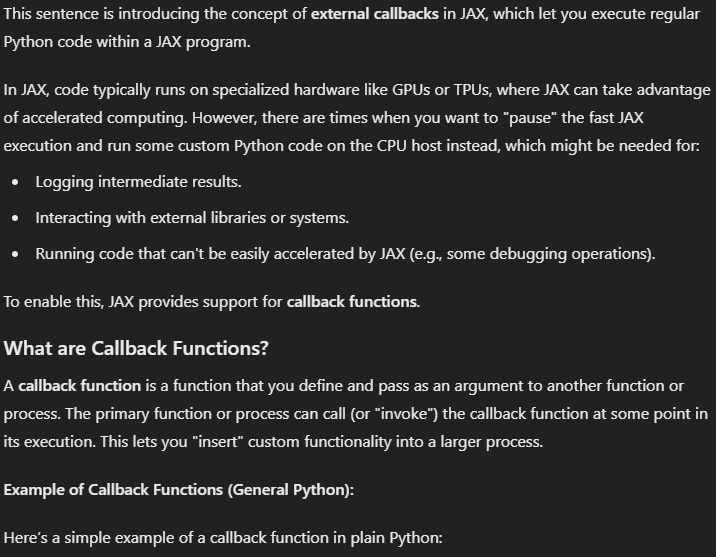

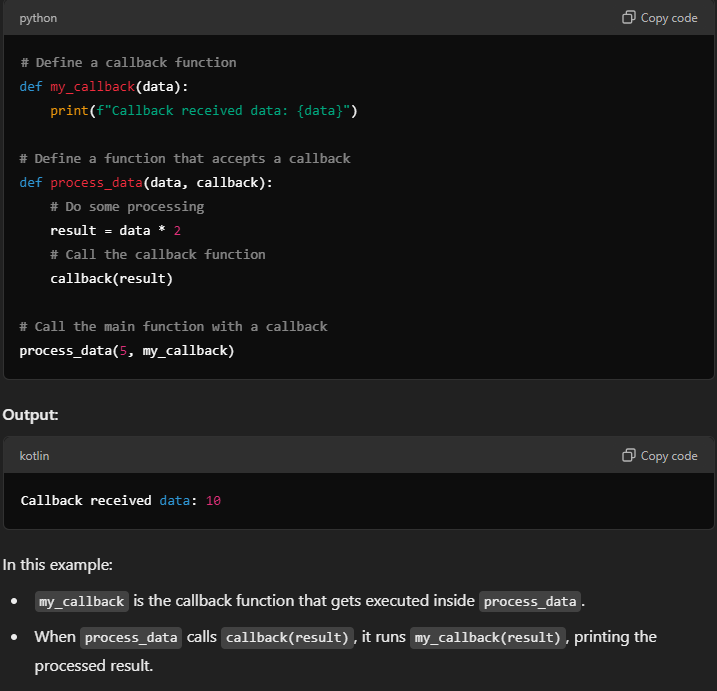

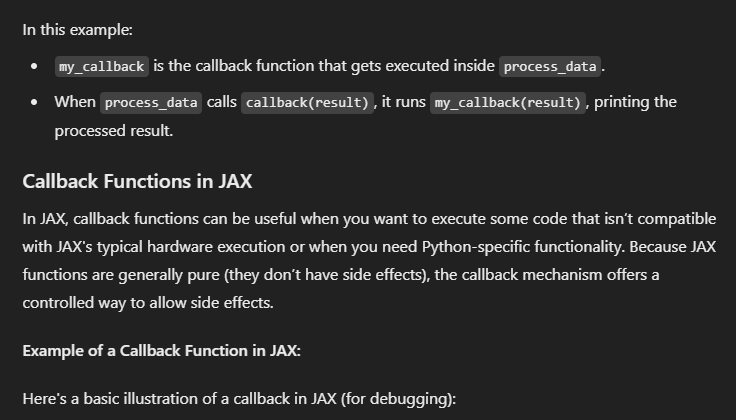

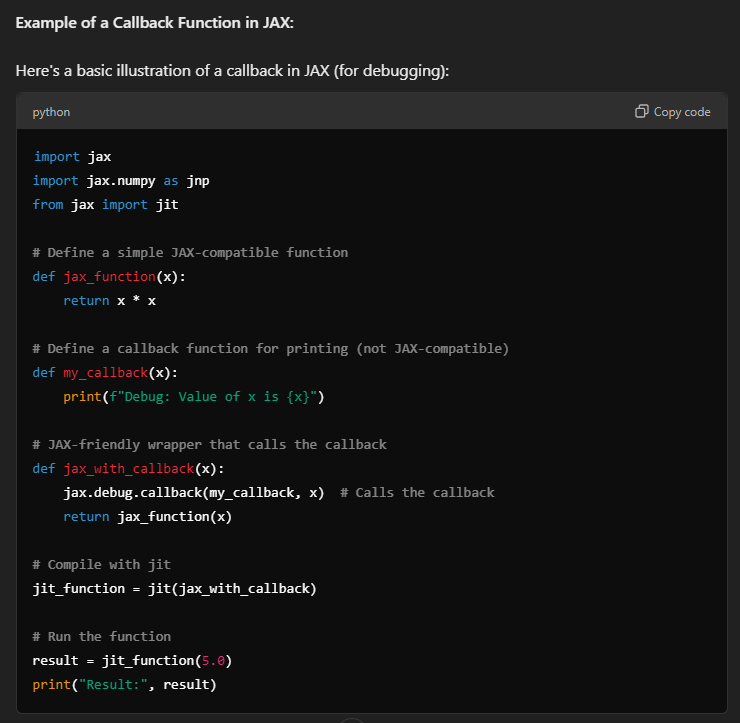

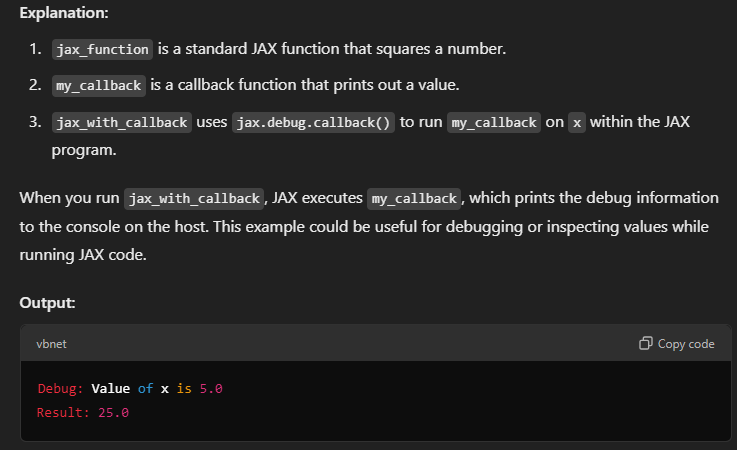

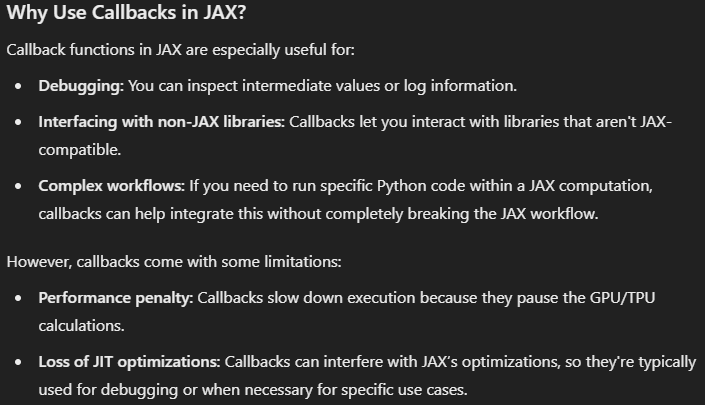

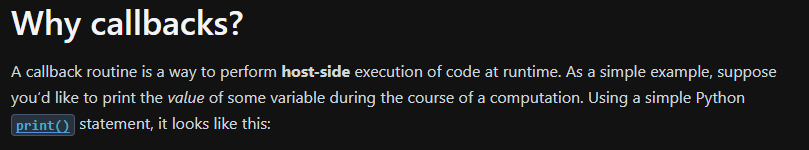

In [2]:
import jax

@jax.jit
def f(x):
  y = x + 1
  print("intermediate value: {}".format(y))
  return y * 2

result = f(2)

intermediate value: Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>


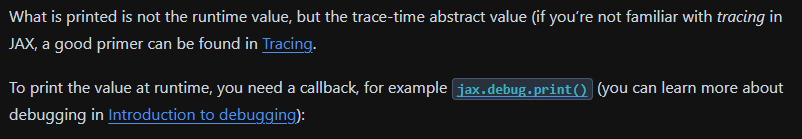

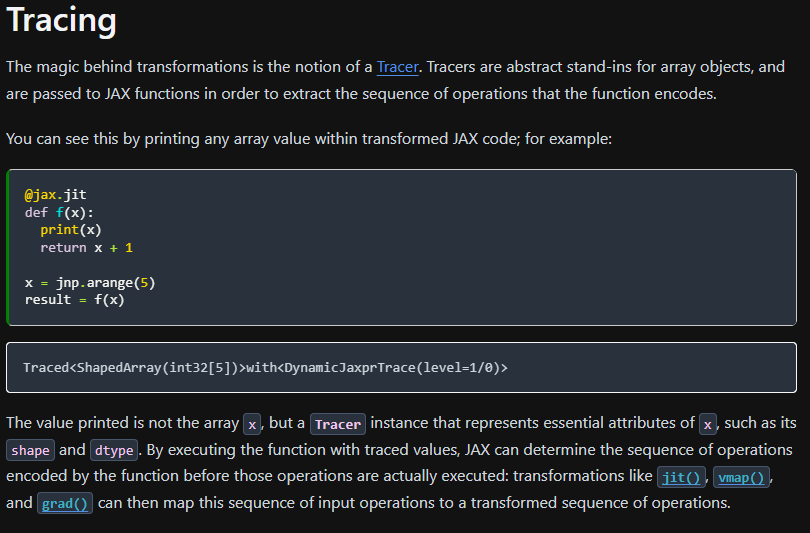

In [3]:
@jax.jit
def f(x):
  y = x + 1
  jax.debug.print("intermediate value: {}", y)
  return y * 2

result = f(2)

intermediate value: 3


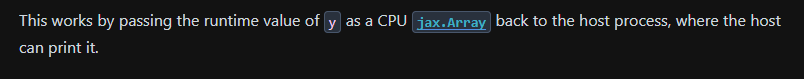

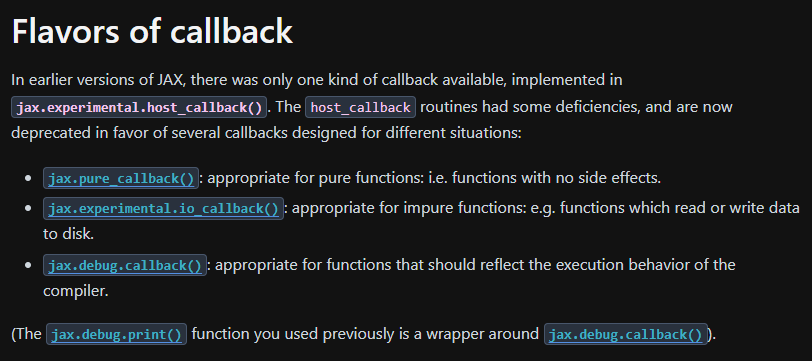

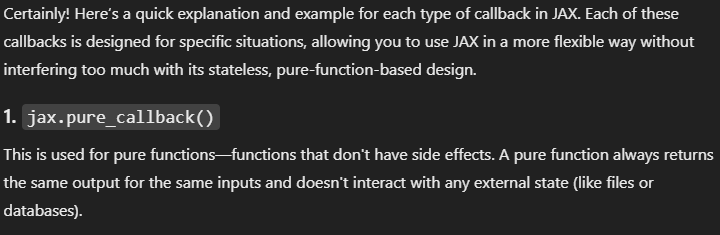

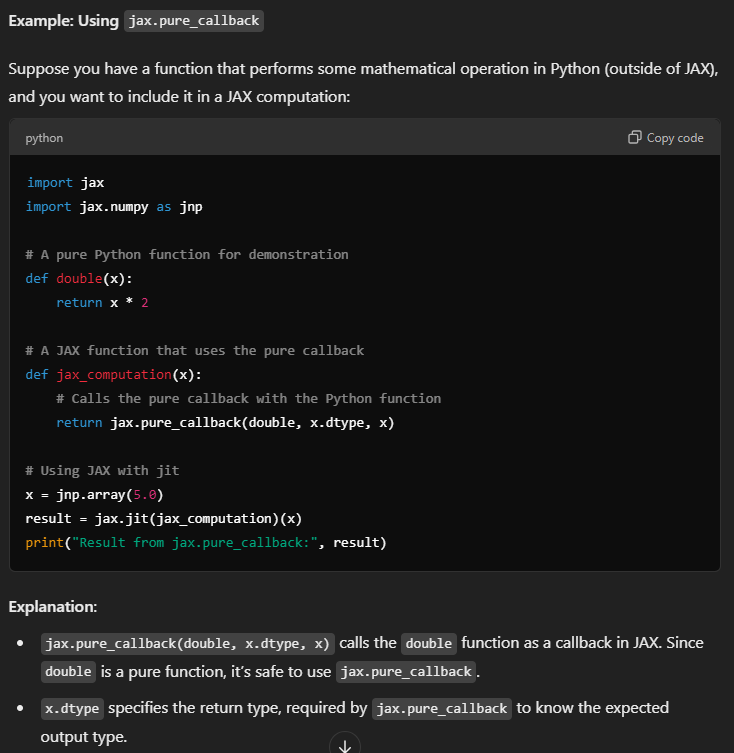

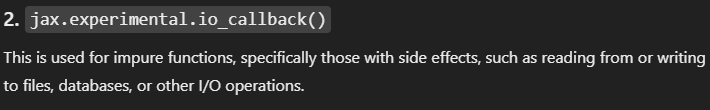

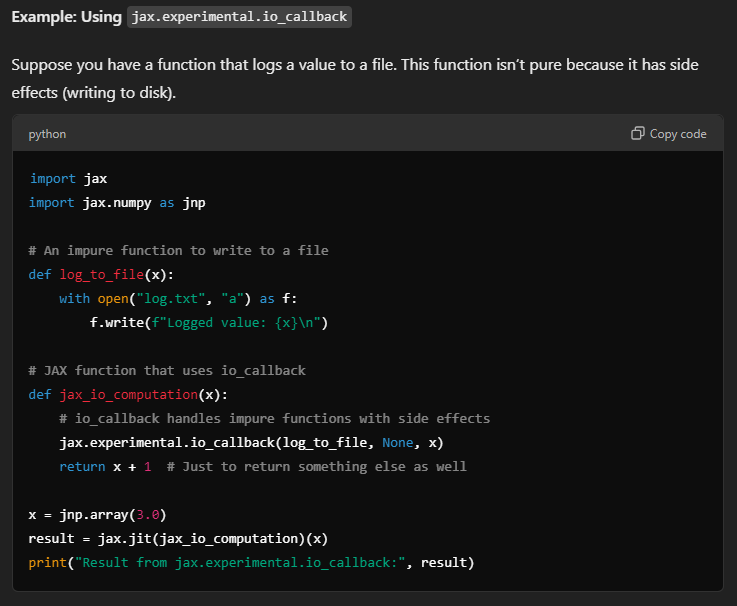

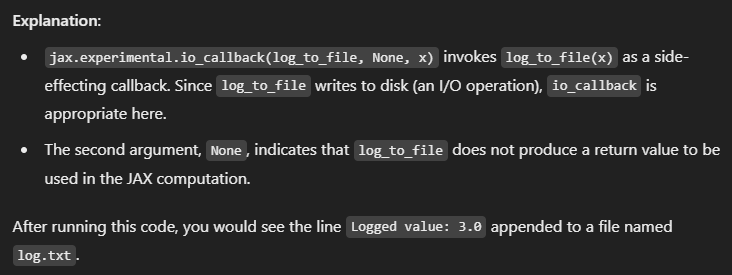

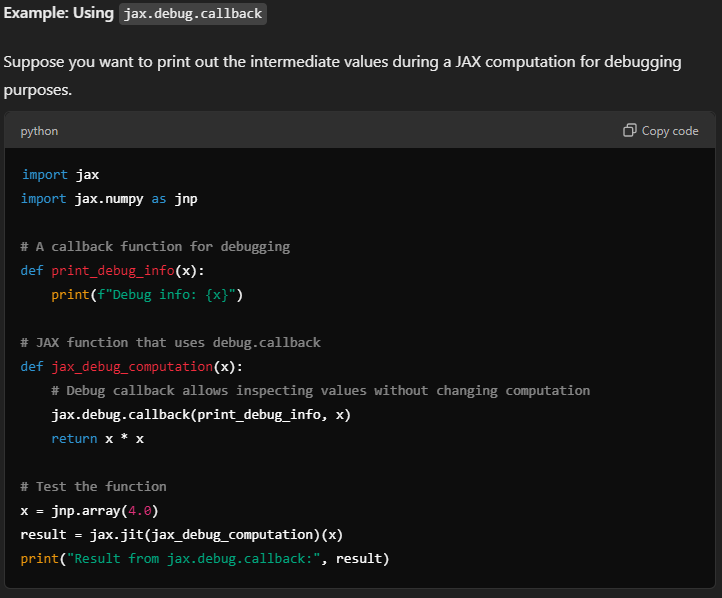

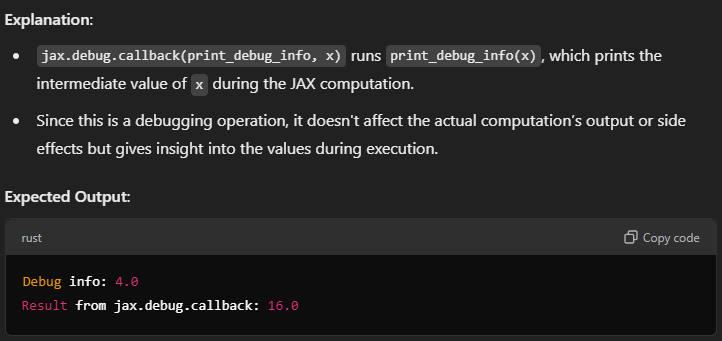

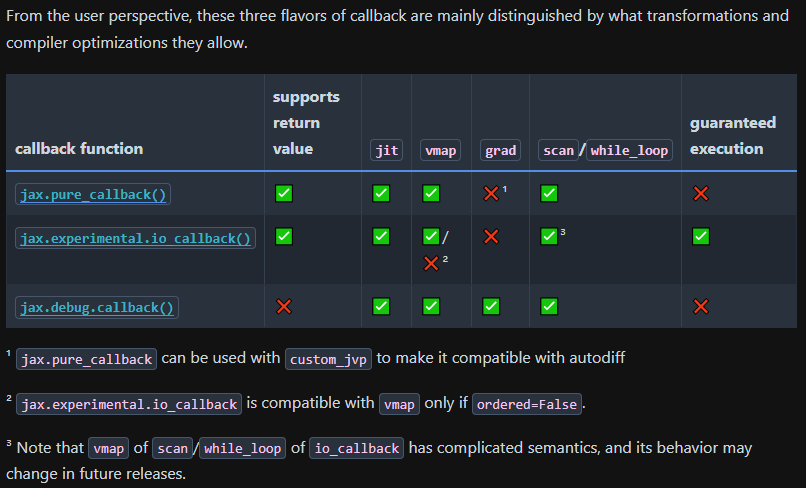

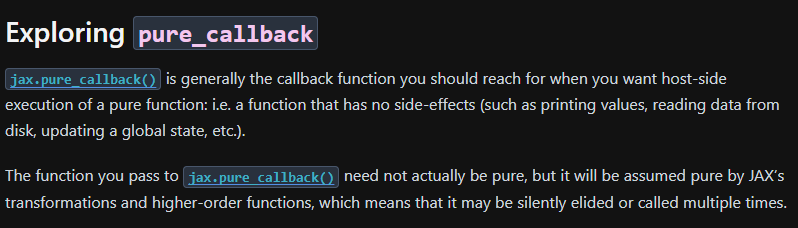

In [4]:
import jax
import jax.numpy as jnp
import numpy as np

def f_host(x):
  # call a numpy (not jax.numpy) operation:
  return np.sin(x).astype(x.dtype)

def f(x):
  result_shape = jax.ShapeDtypeStruct(x.shape, x.dtype)
  return jax.pure_callback(f_host, result_shape, x)

x = jnp.arange(5.0)
f(x)

Array([ 0.       ,  0.841471 ,  0.9092974,  0.14112  , -0.7568025],      dtype=float32)

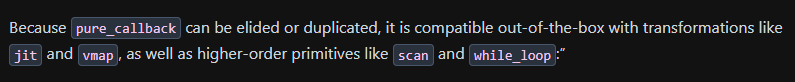

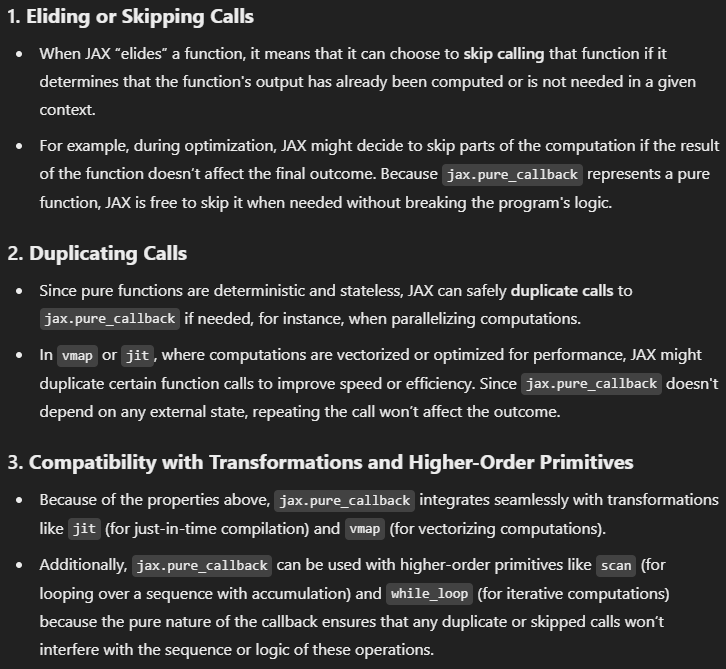

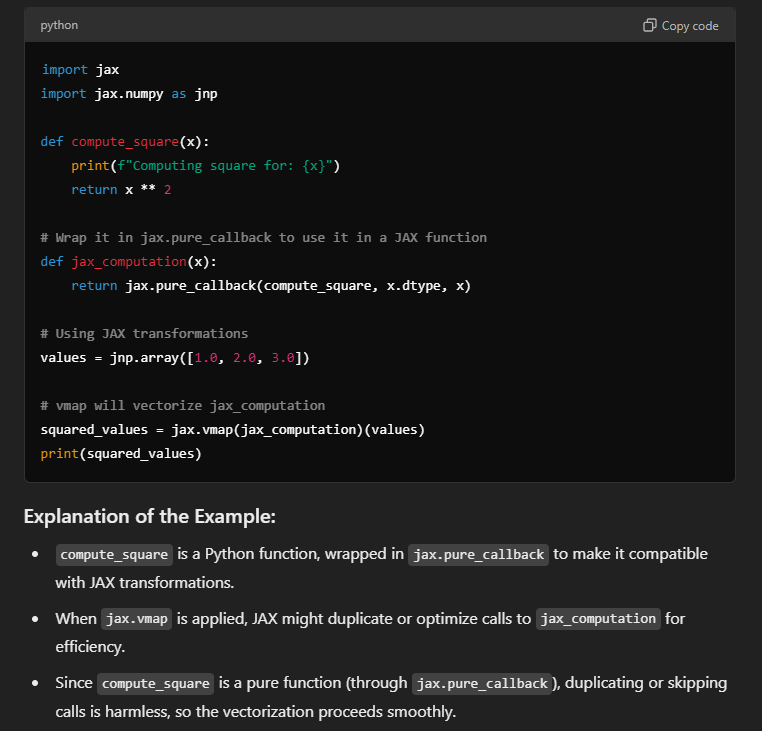

In [5]:
jax.jit(f)(x)

Array([ 0.       ,  0.841471 ,  0.9092974,  0.14112  , -0.7568025],      dtype=float32)

In [6]:
jax.vmap(f)(x)

Array([ 0.       ,  0.841471 ,  0.9092974,  0.14112  , -0.7568025],      dtype=float32)

In [7]:
def body_fun(_, x):
  return _, f(x)
jax.lax.scan(body_fun, None, jnp.arange(5.0))[1]

Array([ 0.       ,  0.841471 ,  0.9092974,  0.14112  , -0.7568025],      dtype=float32)

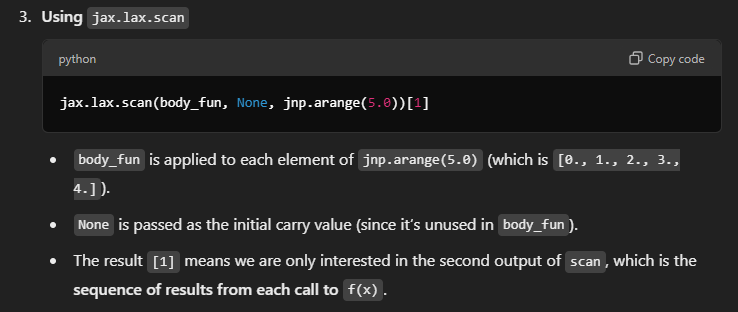

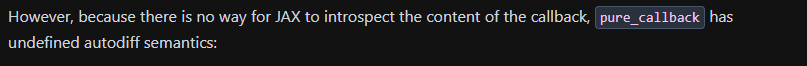

In [8]:
jax.grad(f)(x)

ValueError: Pure callbacks do not support JVP. Please use `jax.custom_jvp` to use callbacks while taking gradients.

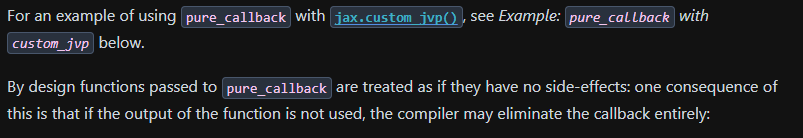

In [9]:
def print_something():
  print('printing something')
  return np.int32(0)

@jax.jit
def f1():
  return jax.pure_callback(print_something, np.int32(0))
f1();

printing something


In [10]:
@jax.jit
def f2():
  jax.pure_callback(print_something, np.int32(0))
  return 1.0
f2();

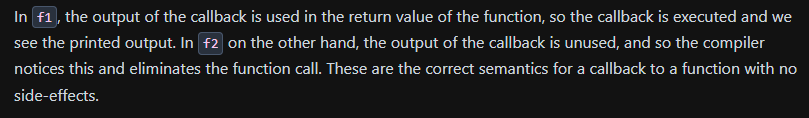

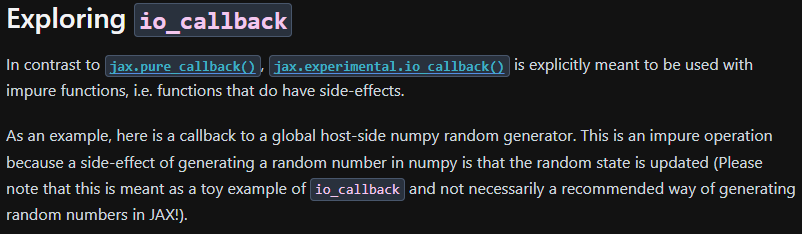

In [13]:
from jax.experimental import io_callback
from functools import partial

global_rng = np.random.default_rng(0)

def host_side_random_like(x):
  """Generate a random array like x using the global_rng state"""
  # We have two side-effects here:
  # - printing the shape and dtype
  # - calling global_rng, thus updating its state
  print(f'generating {x.dtype}{list(x.shape)}')
  return global_rng.uniform(size=x.shape).astype(x.dtype)

@jax.jit
def numpy_random_like(x):
  return io_callback(host_side_random_like, x, x)

x = jnp.zeros(5)
numpy_random_like(x)

generating float32[5]


Array([0.6369617 , 0.26978672, 0.04097353, 0.01652764, 0.8132702 ],      dtype=float32)

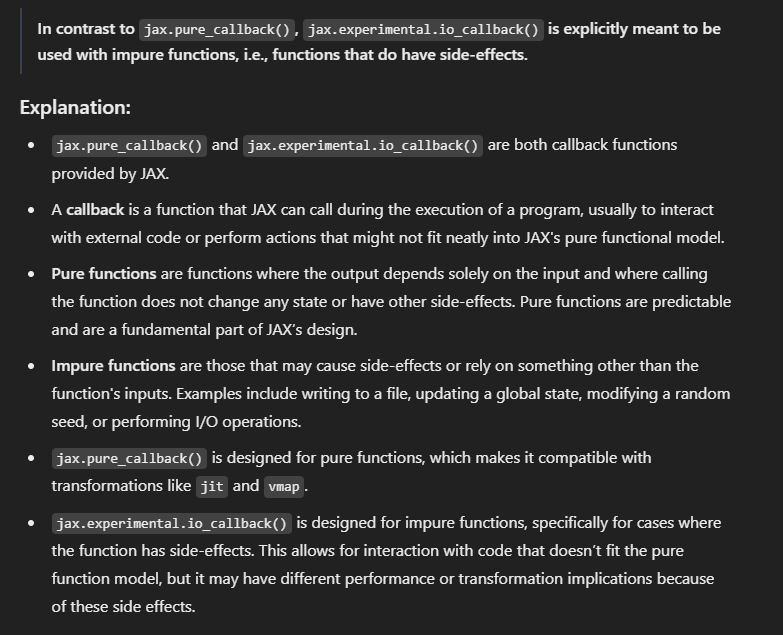

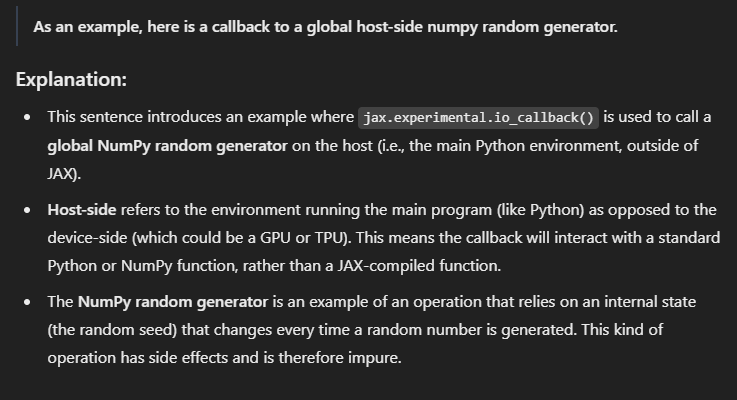

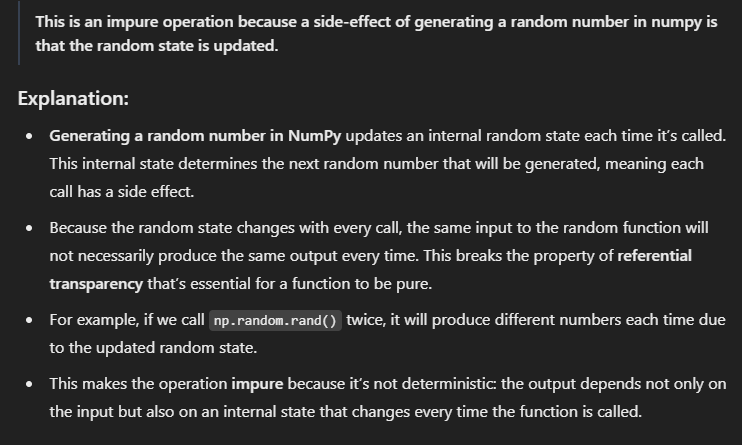

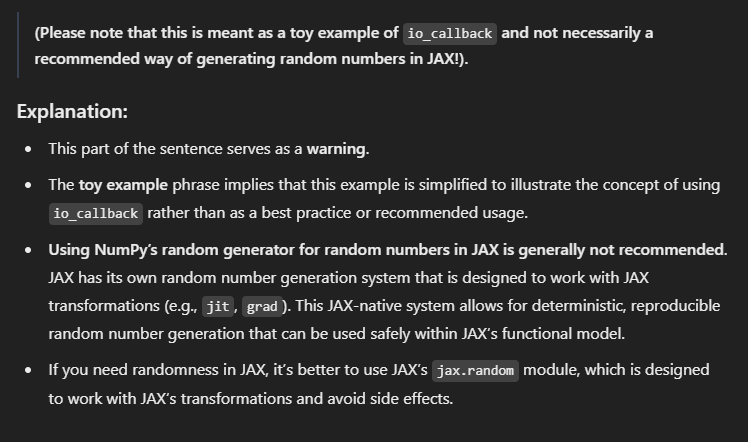

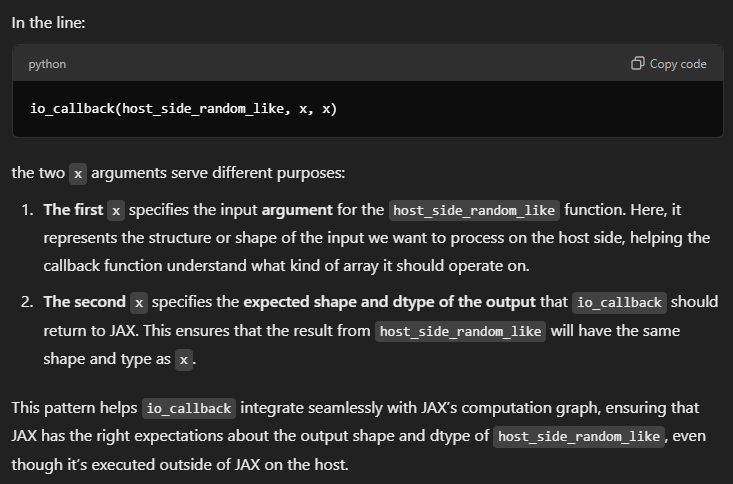

In [14]:
jax.vmap(numpy_random_like)(x)

generating float32[]
generating float32[]
generating float32[]
generating float32[]
generating float32[]


Array([0.91275555, 0.60663575, 0.72949654, 0.543625  , 0.9350724 ],      dtype=float32)

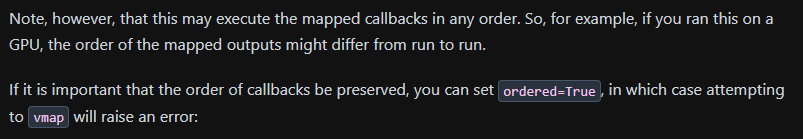

In [15]:
@jax.jit
def numpy_random_like_ordered(x):
  return io_callback(host_side_random_like, x, x, ordered=True)

jax.vmap(numpy_random_like_ordered)(x)

ValueError: Cannot `vmap` ordered IO callback.

In [16]:
def body_fun(_, x):
  return _, numpy_random_like_ordered(x)
jax.lax.scan(body_fun, None, jnp.arange(5.0))[1]

generating float32[]
generating float32[]
generating float32[]
generating float32[]
generating float32[]


Array([0.81585354, 0.0027385 , 0.8574043 , 0.03358557, 0.72965544],      dtype=float32)

In [17]:
def body_fun(_, x):
  return _, numpy_random_like_ordered(x)
jax.lax.scan(body_fun, None, jnp.arange(5.0))[1]

generating float32[]
generating float32[]
generating float32[]
generating float32[]
generating float32[]


Array([0.17565562, 0.8631789 , 0.5414612 , 0.29971188, 0.42268723],      dtype=float32)

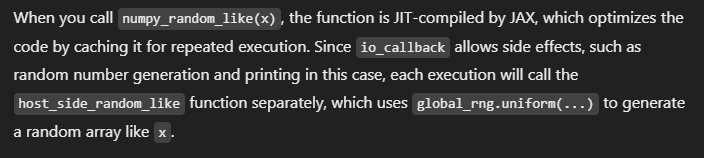

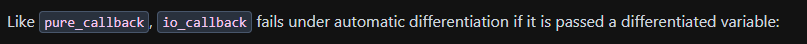

In [18]:
jax.grad(numpy_random_like)(x)

ValueError: IO callbacks do not support JVP.

In [19]:
@jax.jit
def f(x):
  io_callback(lambda: print('hello'), None)
  return x

jax.grad(f)(1.0);

hello


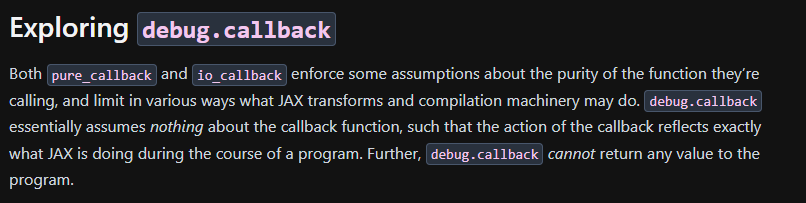

In [20]:
from jax import debug

def log_value(x):
  # This could be an actual logging call; we'll use
  # print() for demonstration
  print("log:", x)

@jax.jit
def f(x):
  debug.callback(log_value, x)
  return x

f(1.0);

log: 1.0


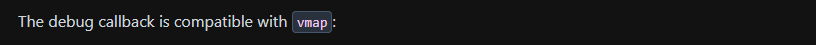

In [21]:
x = jnp.arange(5.0)
jax.vmap(f)(x);

log: 0.0
log: 1.0
log: 2.0
log: 3.0
log: 4.0


In [22]:
jax.grad(f)(1.0);

log: 1.0


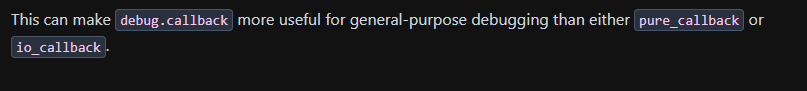

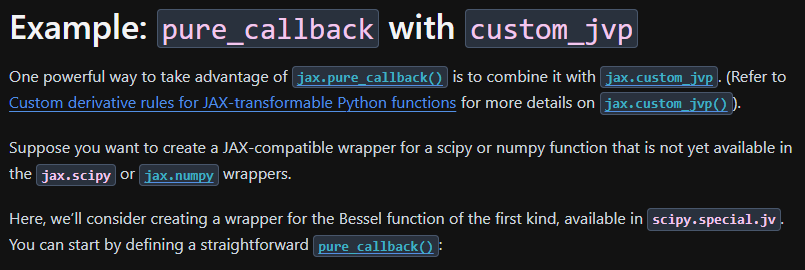

In [23]:
import jax
import jax.numpy as jnp
import scipy.special

def jv(v, z):
  v, z = jnp.asarray(v), jnp.asarray(z)

  # Require the order v to be integer type: this simplifies
  # the JVP rule below.
  assert jnp.issubdtype(v.dtype, jnp.integer)

  # Promote the input to inexact (float/complex).
  # Note that jnp.result_type() accounts for the enable_x64 flag.
  z = z.astype(jnp.result_type(float, z.dtype))

  # Wrap scipy function to return the expected dtype.
  _scipy_jv = lambda v, z: scipy.special.jv(v, z).astype(z.dtype)

  # Define the expected shape & dtype of output.
  result_shape_dtype = jax.ShapeDtypeStruct(
      shape=jnp.broadcast_shapes(v.shape, z.shape),
      dtype=z.dtype)

  # You use vectorize=True because scipy.special.jv handles broadcasted inputs.
  return jax.pure_callback(_scipy_jv, result_shape_dtype, v, z, vectorized=True)

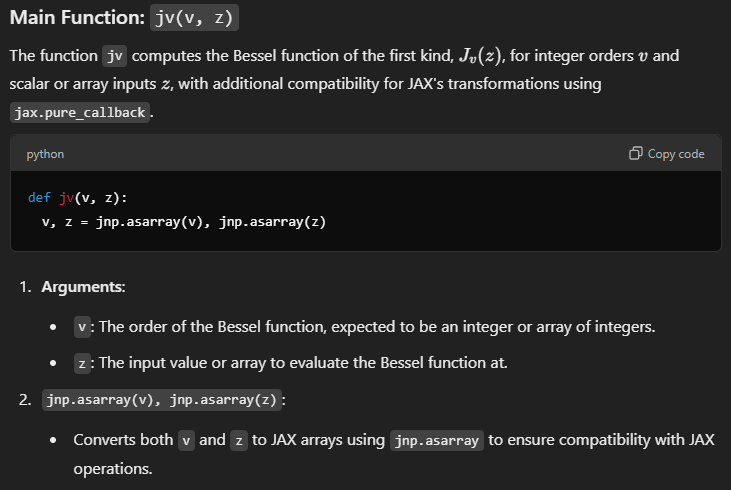

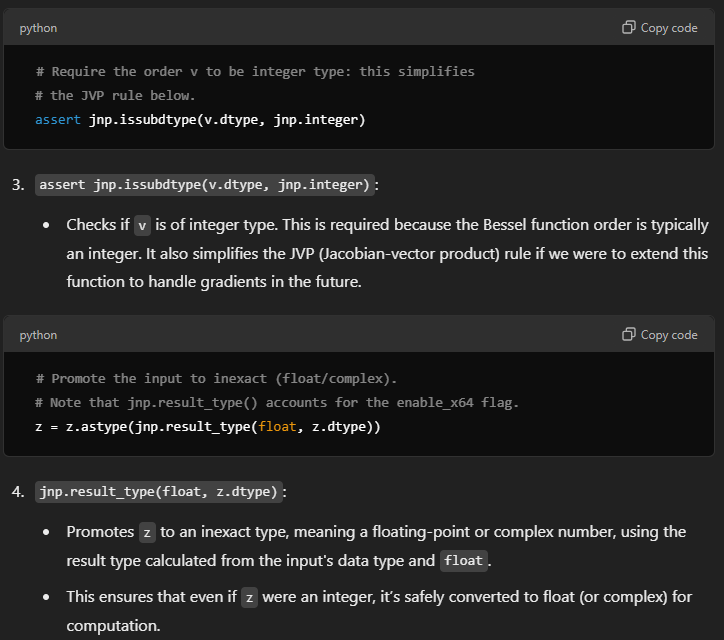

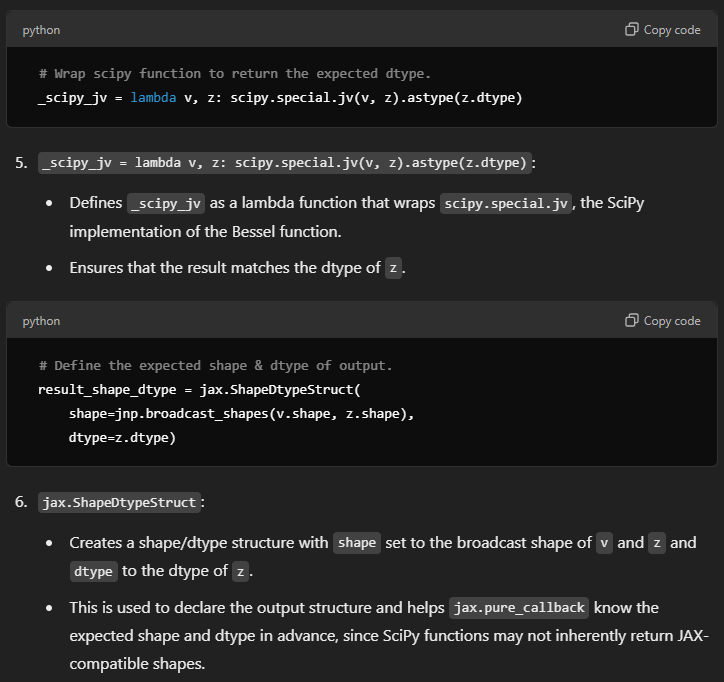

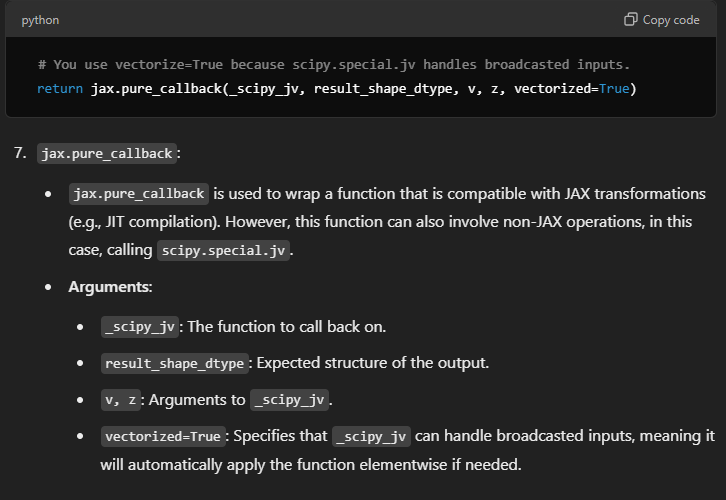

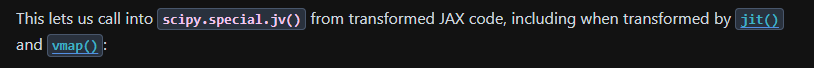

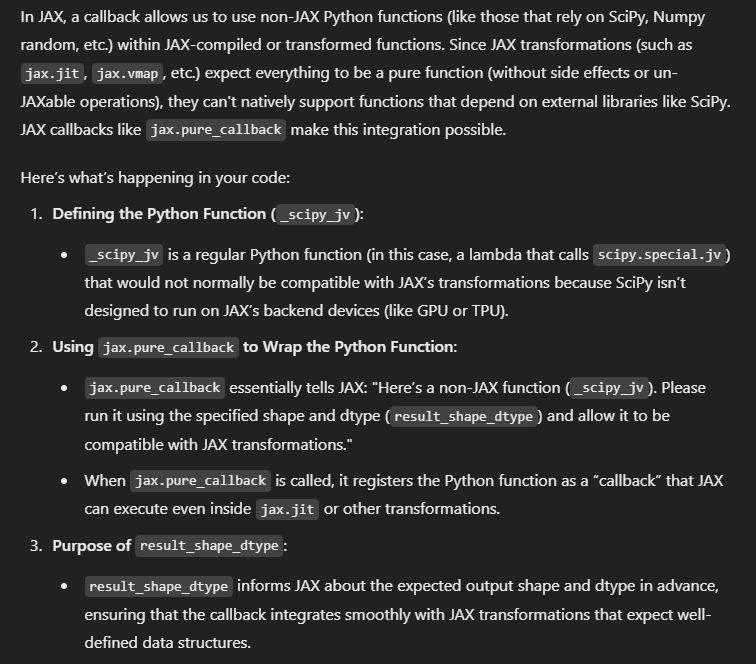

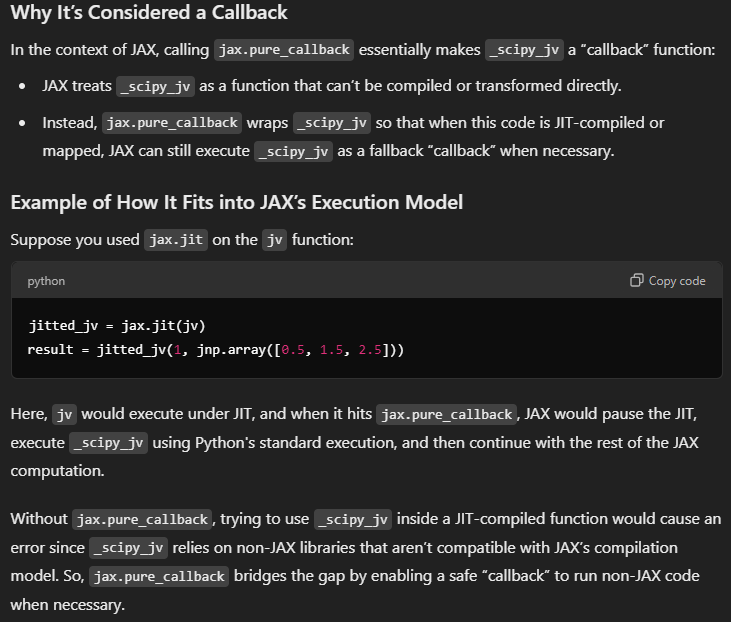

In [24]:
from functools import partial
j1 = partial(jv, 1)
z = jnp.arange(5.0)

In [25]:
print(j1(z))

[ 0.          0.44005057  0.5767248   0.33905897 -0.06604332]


In [26]:
print(jax.jit(j1)(z))

[ 0.          0.44005057  0.5767248   0.33905897 -0.06604332]


In [27]:
print(jax.vmap(j1)(z))

[ 0.          0.44005057  0.5767248   0.33905897 -0.06604332]


In [28]:
jax.grad(j1)(z)

ValueError: Pure callbacks do not support JVP. Please use `jax.custom_jvp` to use callbacks while taking gradients.

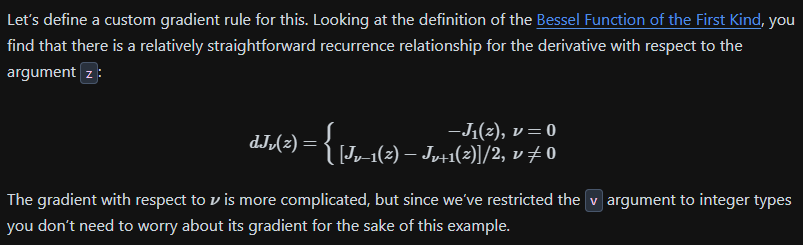

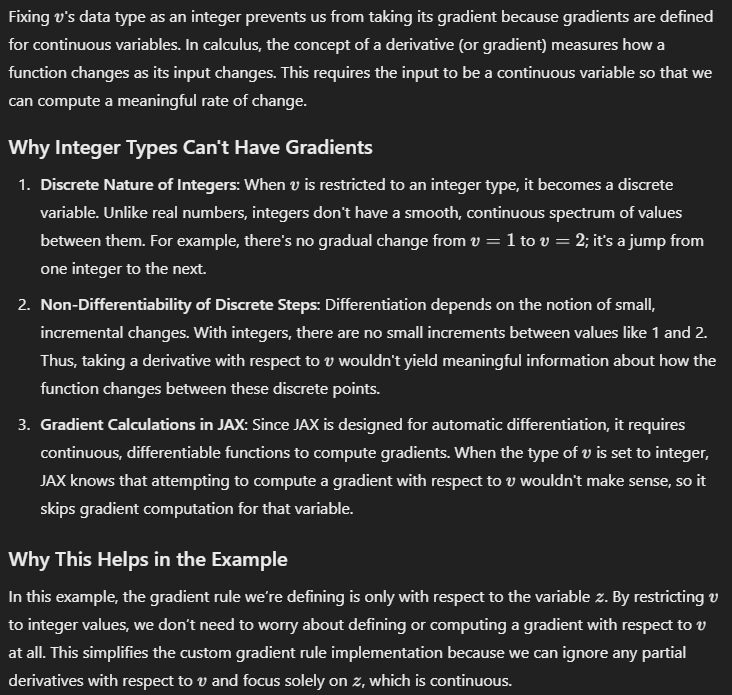

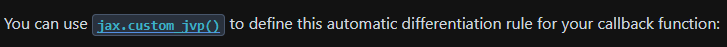

In [29]:
jv = jax.custom_jvp(jv)

@jv.defjvp
def _jv_jvp(primals, tangents):
  v, z = primals
  _, z_dot = tangents  # Note: v_dot is always 0 because v is integer.
  jv_minus_1, jv_plus_1 = jv(v - 1, z), jv(v + 1, z)
  djv_dz = jnp.where(v == 0, -jv_plus_1, 0.5 * (jv_minus_1 - jv_plus_1))
  return jv(v, z), z_dot * djv_dz

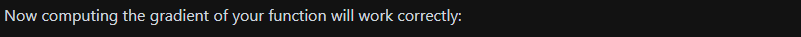

In [30]:
j1 = partial(jv, 1)
print(jax.grad(j1)(2.0))

-0.06447162


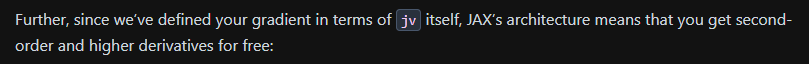

In [31]:
jax.hessian(j1)(2.0)

Array(-0.4003078, dtype=float32, weak_type=True)

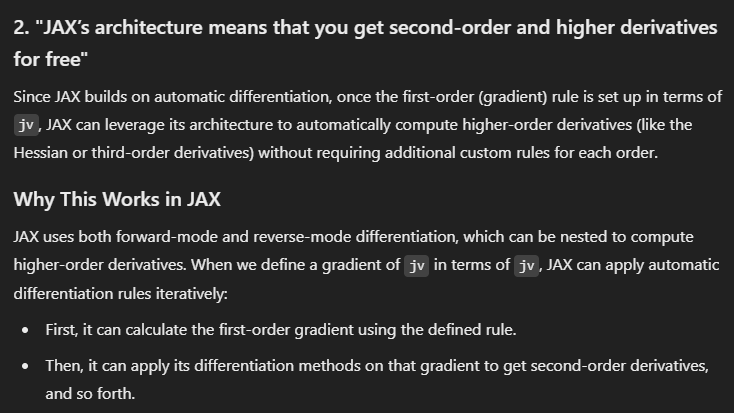

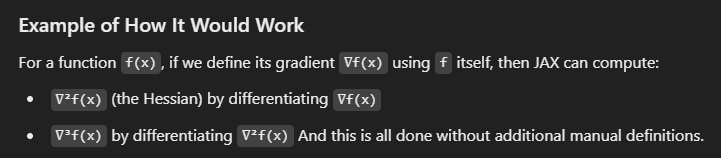

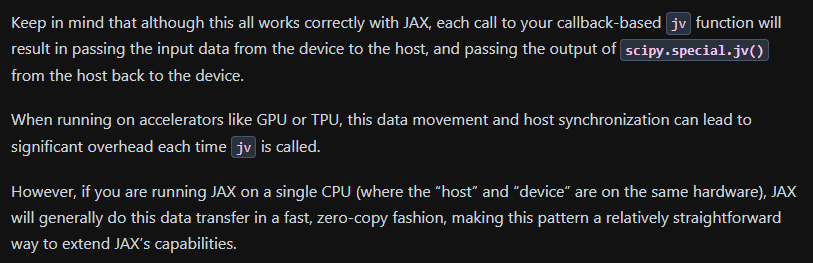